# Checking on GPU

In [1]:
#@title Print TF version and GPU stats
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
   raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name), '', sep='\n')
!nvidia-smi

TensorFlow version: 2.7.0
Found GPU at: /device:GPU:0

Sun Jan 23 19:12:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    30W /  70W |    264MiB / 15109MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                 

# Import and preprocess of the data

In [2]:
from tensorflow.keras.datasets import cifar10
(train_X, train_y), (test_X, test_y) = cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


In [3]:
#We need to make onehot vectors out of the labels
from tensorflow.keras.utils import to_categorical
train_y = to_categorical(train_y,num_classes=10)
test_y = to_categorical(test_y,num_classes=10)

In [4]:
#title Prepare Data Generators
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 512

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   zoom_range=0.4,
                                   brightness_range=(.5, 1.5),
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow(
                    train_X, train_y,
                    batch_size=batch_size,
                    shuffle=False)

num_classes = 10

# Flow test images in batches using val_datagen generator
test_generator = test_datagen.flow(
                    test_X, test_y,
                    batch_size=batch_size,
                    shuffle=False)

train_steps = len(train_generator)
test_steps = len(test_generator)

# Model definition and compilation

## ResNet50 with BatchNorm

In [5]:
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

def classifier(inputs):
    x = layers.GlobalAveragePooling2D()(inputs)
    x = layers.Dense(10, activation="softmax", name="classification")(x)
    return x

def build_model(input_shape,summary=True, init_lr=1e-3):

  # Initialize the pre-trained model
  input = layers.Input(shape=(32,32,3))

  #investigate how to get rid of BatchNorm model
  pre_trained_model = ResNet50(input_shape=None,
                               weights=None,
                               include_top=False
                               )


  extractor = pre_trained_model(input)
  output = classifier(extractor)

  # Define the model
  model = Model(input, output, name='ResNet50')

  model.compile(loss='categorical_crossentropy',
                optimizer=Adam(learning_rate=init_lr),
                metrics=['accuracy'])

  if summary:
    print(model.summary())

  return model

In [6]:
resnet_model = build_model((32,32,3))

Model: "ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 classification (Dense)      (None, 10)                20490     
                                                                 
Total params: 23,608,202
Trainable params: 23,555,082
Non-trainable params: 53,120
_________________________________________________________________
None


In [7]:
#@title `plot_history()` definition
from matplotlib import pyplot as plt

def plot_history(history):
  fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, dpi=150)
  ax1.plot(history.history['loss'], label='training')
  ax1.plot(history.history['val_loss'], label='validation')
  ax1.set_ylabel('Cross-Entropy Loss')
  ax1.set_yscale('log')
  if history.history.__contains__('lr'):
    ax1b = ax1.twinx()
    ax1b.plot(history.history['lr'], 'g-', linewidth=1)
    ax1b.set_yscale('log')
    ax1b.set_ylabel('Learning Rate', color='g')

  ax2.plot(history.history['accuracy'], label='training')
  ax2.plot(history.history['val_accuracy'], label='validation')
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.legend()
  plt.show() 

Epoch 1/100
98/98 [==============================] - 63s 454ms/step - loss: 2.2602 - accuracy: 0.2468 - val_loss: 2.3891 - val_accuracy: 0.1000
Epoch 2/100
98/98 [==============================] - 38s 391ms/step - loss: 1.8699 - accuracy: 0.3333 - val_loss: 2.5347 - val_accuracy: 0.1222
Epoch 3/100
98/98 [==============================] - 38s 391ms/step - loss: 1.8114 - accuracy: 0.3662 - val_loss: 2.5457 - val_accuracy: 0.1534
Epoch 4/100
98/98 [==============================] - 38s 391ms/step - loss: 1.7468 - accuracy: 0.3905 - val_loss: 2.4563 - val_accuracy: 0.1786
Epoch 5/100
98/98 [==============================] - 38s 388ms/step - loss: 1.7675 - accuracy: 0.3822 - val_loss: 2.4627 - val_accuracy: 0.1738
Epoch 6/100
98/98 [==============================] - 38s 390ms/step - loss: 1.7960 - accuracy: 0.3772 - val_loss: 21.3731 - val_accuracy: 0.1169
Epoch 7/100
98/98 [==============================] - 38s 390ms/step - loss: 1.6698 - accuracy: 0.4184 - val_loss: 1.6374 - val_accuracy

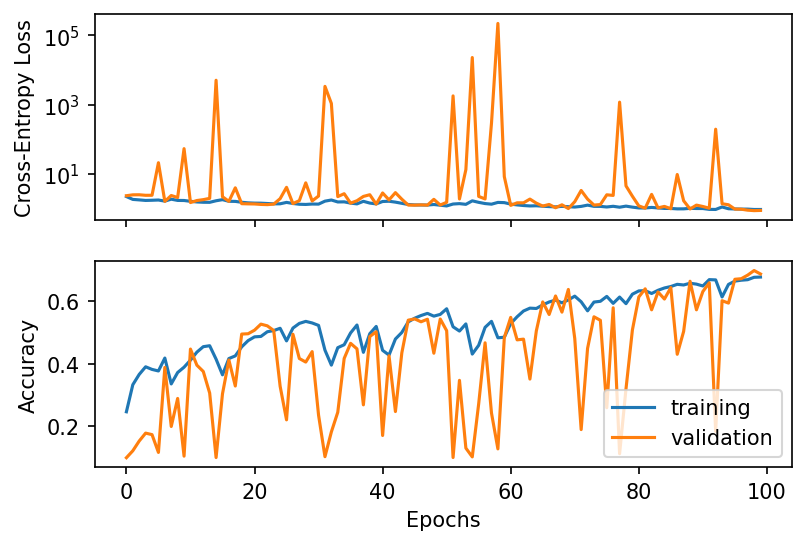

In [8]:
history = resnet_model.fit(train_generator,
                          steps_per_epoch=train_steps,# trained with 512
                          epochs=100,
                          validation_data=test_generator,
                          validation_steps=test_steps
                          )
plot_history(history)